# Unsupervised dimensionality reduction via principal component analysis
Dimensionality reduction can be understood as an approach to data compression with the goal of maintaining most of the relevant information.

## Main steps in PCA (Principal Component Analysis)
We have to transform $x\in \mathbb{R}^d$ into $z\in \mathbb{R}^k$, where $k<d$ using a trasformation matrix $W\in \mathbb{R}^{d\times k}$, so that to gain $z$ we just need to do $x^T W = z$.

We now have just to calculate the transformation matrix $W$.

Note that PCA directions are higly sensitive to data scaling, so we need to standardize the features prior to PCA if the features were measured on different scales, and we want to assign equal importance to all features.

The approach will be the following:
- Standardize the $d$-dimensional dataset;
- Construct the covariance matrix;
    - > It's a matrix that's identical to its transposed version (so it's symmetric)
- Decompose the covariance matrix into its eigenvectors and eigenvalues;
    - > Decomposing a symmetric matrix into eigenvectors and eigenvalues allows us to have real eigenvalues (reather than complex ones), and orthogonal eigenvectors;
    - > The max valued eigenvector (using the values of the corresponding eigenvalues), will correspond to the direction of maximum variance in the dataset;
    - > Remember that we are focused on variance since it retains much of the information.
- Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors;
- Select $k$ eigenvectors, which correspond to the $k$ largest eigenvalues, where $k$ is the dimensionality of the new feature subspace;
- Construct a projection matrix, $W$, from the "top" eigenvectors;
- Transform the $d$-dimensional input dataset, $X$, using the projection matrix, $W$, to obtain the $k$-dimensional feature subspace.

### Extracting components

In [39]:
import pandas as pd
df_wine = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data",
    header=None,
)

from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

The covariance formula is the following:
$$
\sigma_{jk}=\frac{1}{n-1}\sum_{i=1}^n (x_j^{(i)} - \mu_j)(x_k^{(i)} - \mu_k)
$$
This analyzes the covariance between the feature $j$ and the feature $k$. If the number is positive the two features increase and decrease together, while if the number is negative the two features increase and decrease in opposite directions.

Note that the averages ($\mu$) are 0 since we standardized every feature.

The _covariance matrix_ simply analyzes the covariance between each feature (and it's symmetrical because the covariance between feature 1 and 2 is the same of feature 2 and 1).

The eigenvectors of the covariance matrix represent the principal compo ents (directions of maximum variance), while the corresponding eigenvalues will define their magnitude.

In [40]:
import numpy as np
cov_mat = np.cov(X_train_std.T) # computation of the covariance matrix
eig_vals, eig_vecs = np.linalg.eig(cov_mat) # eigen decomposition. NOTE: eig_vec is a matrix
print(f"Eigenvalues: \n{eig_vals}")
# (1/(len(X_train_std)-1))*(np.dot(X_train_std.T,X_train_std)) calcolo della covariance matrix

Eigenvalues: 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


The `np.linalg.eigh` function is more numerically stable, and always returns real number (in case it's a necessity) (it operates with hermetian matrixes).

Let's dig into the variance explained ratio of an eigenvalue $\lambda_j$:
$$
\text{Explained variance ratio} = \frac{\lambda_j}{\sum_{i=1}^d \lambda_i}
$$

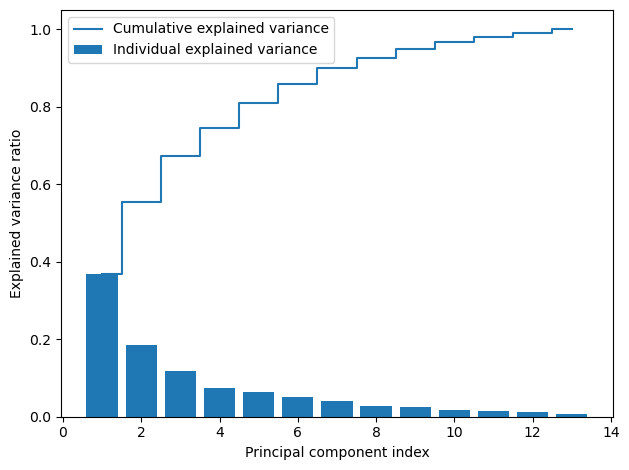

In [41]:
tot = sum(eig_vals)
var_exp = [(i/tot) for i in sorted(eig_vals,reverse=True)]
cum_var_exp = np.cumsum(var_exp)
import matplotlib.pyplot as plt
plt.bar(range(1,14),var_exp, align='center',label="Individual explained variance")
plt.step(range(1,14),cum_var_exp, where='mid',label="Cumulative explained variance")
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Feature transformation

In [44]:
eig_pairs = [(eig_vals[i],eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda k: k[0],reverse=True)
W = np.hstack(
    (
        eig_pairs[0][1][:,np.newaxis],
        eig_pairs[1][1][:,np.newaxis]
    )
)
print(f'Matrix W: \n{W}')

Matrix W: 
[[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


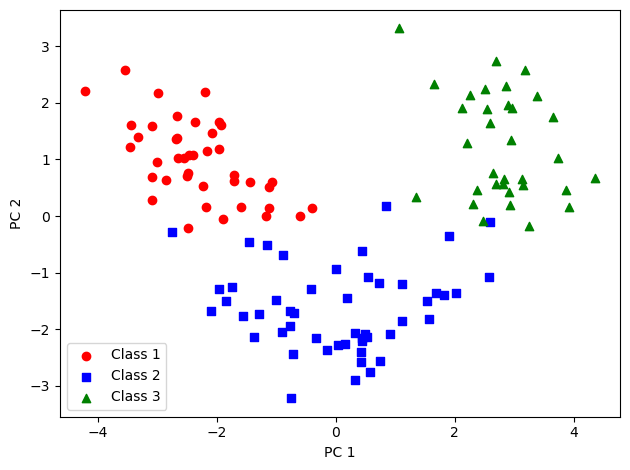

In [45]:
X_train_pca = X_train_std.dot(W)

colors = ['r','b','g']
markers = ['o','s','^']
for l,c,m in zip(np.unique(y_train),colors,markers):
    plt.scatter(
        X_train_pca[y_train==l,0],
        X_train_pca[y_train==l,1],
        c=c, label=f'Class {l}', marker=m
    )

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## PCA in sklearn

In [46]:
from matplotlib.colors import ListedColormap

# Rewriting the function here to use it throughout the notebook
def plot_decision_regions(
    X: np.ndarray, y: np.ndarray, classifier, test_idx=None, resolution: float = 0.02
):
    markers = ("o", "s", "^", "v", "<")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[: len(np.unique(y))])

    x1_min, x1_max = (
        X[:, 0].min() - 1,
        X[:, 0].max() + 1,
    )  # extracting min and max for the first feature
    x2_min, x2_max = (
        X[:, 1].min() - 1,
        X[:, 1].max() + 1,
    )  # extracting min and max for the second feature

    """
    Everything until the contour function (comprehended) it's used to generate a list of dots in the surface, to use to make
    predictions. Those predictions will be used by the contour function to create contour regions.
    """
    xx1, xx2 = np.meshgrid(
        np.arange(
            x1_min, x1_max, resolution
        ),  # it makes a fake range of values, comprehended in the true range of the first feature
        np.arange(
            x2_min, x2_max, resolution
        ),  # it makes a fake range of values, comprehended in the true range of the second feature
    )
    # Practically speaking, the meshgrid makes it possible to evaluate the function (represented by the perceptron) on evenly
    # spaced (depending on the selected resolution) points.

    lab = classifier.predict(
        np.array(
            [
                xx1.ravel(),  # it makes the xx1 matrix in vector form (1 dimension, following the correct order)
                xx2.ravel(),  # it makes the xx2 matrix in vector form (1 dimension, following the correct order)
            ]
        ).T
    )
    lab = lab.reshape(xx1.shape)
    plt.contourf(
        xx1, xx2, lab, alpha=0.3, cmap=cmap
    )  # it draws contour areas based on the coordinates of a mesh grid
    # - xx1 is the X axis
    # - xx2 is the Y axis
    # - lab is the Z axis (corresponding to the predictions)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # that's simply used to plot the single points of the different classes
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=f"Class {cl}",
            edgecolors="black",
        )

    # higlighting test examples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c="none",
            edgecolor="black",
            alpha=1.0,
            linewidth=1,
            marker="o",
            s=100,
            label="Test set",
        )

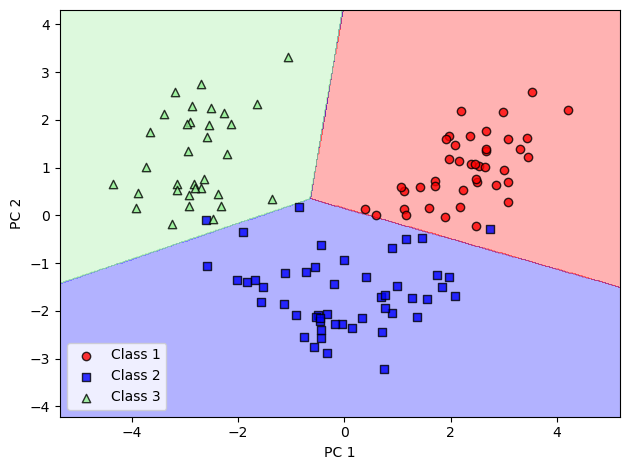

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
lr = LogisticRegression(random_state=1,solver='lbfgs')

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit_transform(X_test_std)

lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca,y_train,classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

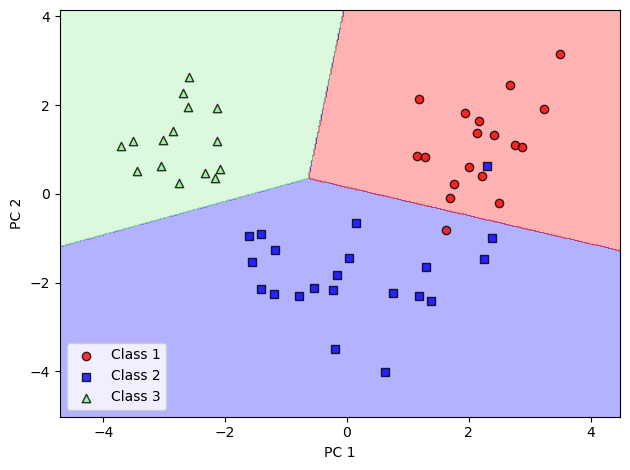

In [48]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

In [50]:
# To gain the explained variance ratio
pca2 = PCA(n_components=None) # to utilize all of the components
pca2.fit_transform(X_train_std)
pca2.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

### Assessing feature contributions

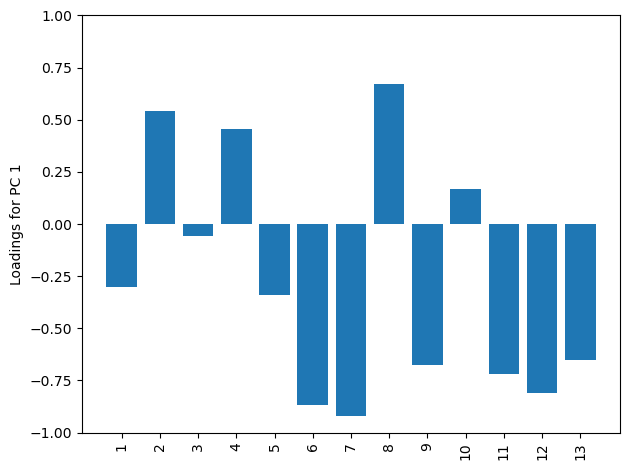

In [52]:
loadings = eig_vecs * np.sqrt(eig_vals)
fig, ax = plt.subplots()
ax.bar(range(13), loadings[:,0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:],rotation=90)
plt.ylim([-1,1])
plt.tight_layout()
plt.show()

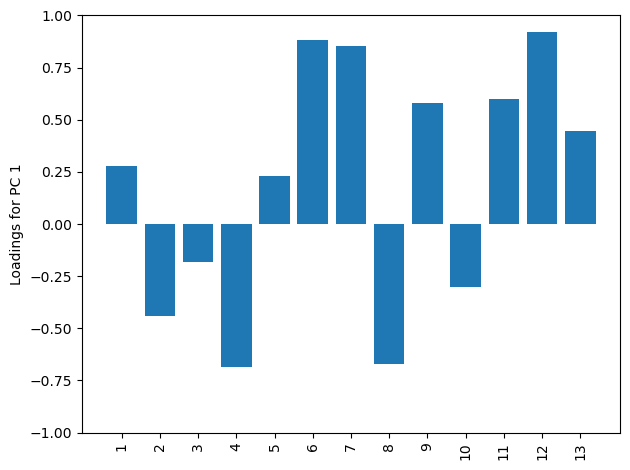

In [53]:
# The same thing in sklearn can be achieved by:
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
fig, ax = plt.subplots()
ax.bar(range(13), sklearn_loadings[:,0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:],rotation=90)
plt.ylim([-1,1])
plt.tight_layout()
plt.show()

# Linear Discriminant Analysis
Similar to PCA but tries to find the feature subspace that optimizes class separability. (It's supervised)

It works under some assumptions, for example like that the data is normally distributed, and that the classes have identical covariance matrices. However, even if one, or more, of those assumptions is (slightly) violated, LDA can still work reasonably well.

It works like this:
1. Standardize the $d$-dimensional dataset;
2. For each class, compute the $d$-dimensional mean vector;
3. Construct the between-class scatter matrix, $S_B$, and the within-class scatter matrix, $S_W$;
4. Compute the eigenvectors and corresponding eigenvalues of the matrix, $S^{-1}_W S_B$;
5. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors;
6. Choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues to construct a $d\times k$-dimensional transformation matrix, $W$; the eigenvectors are the columns of this matrix;
7. Project the examples onto the new feature subspace using the transformation matrix, $W$.

## Computing scatter matrices

In [54]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label],axis=0))
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



Individual (for each individual class) scatter matrix:
$$
S_i = \sum_{x\in D_i} (x - \mu_i)(x - \mu_i)^T
$$
It's similar to the covariance matrix, but here we are using knowledge coming from classes lables, and the covariance matrix it's normalized.

Within-class scatter matrix:
$$
S_w = \sum_{i=1}^c S_i
$$

In [56]:
d = 13
S_W = np.zeros((d,d))
for label, mv in zip(range(1,4),mean_vecs):
    # FOLLOWING FORUMULAS
    # class_scatter = np.zeros((d,d))
    # for row in X_train_std[y_train==label]:
    #     row, mv = row.reshape(d,1), mv.reshape(d,1)
    #     class_scatter += (row-mv.dot((row-mv).T))

    # SCALED WITHIN CLASS SCATTER MATRIX (that is equal to the covariance matrix)
    class_scatter = np.cov(X_train_std[y_train==label].T) # we have to scale it since LDA assumes equal distribution of labels

    S_W += class_scatter

print(f'Within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 13x13


Between class scatter matrix $S_B$:
$$
S_i = \sum_{i=1}^c n_i(\mu_i - \mu)(\mu_i - \mu)^T
$$

In [57]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d,1)

S_B = np.zeros((d,d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    S_B += n*(mean_vec-mean_overall).dot((mean_vec-mean_overall).T)
print(f'Between-class scatter matrix: {S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 13x13
